# phase

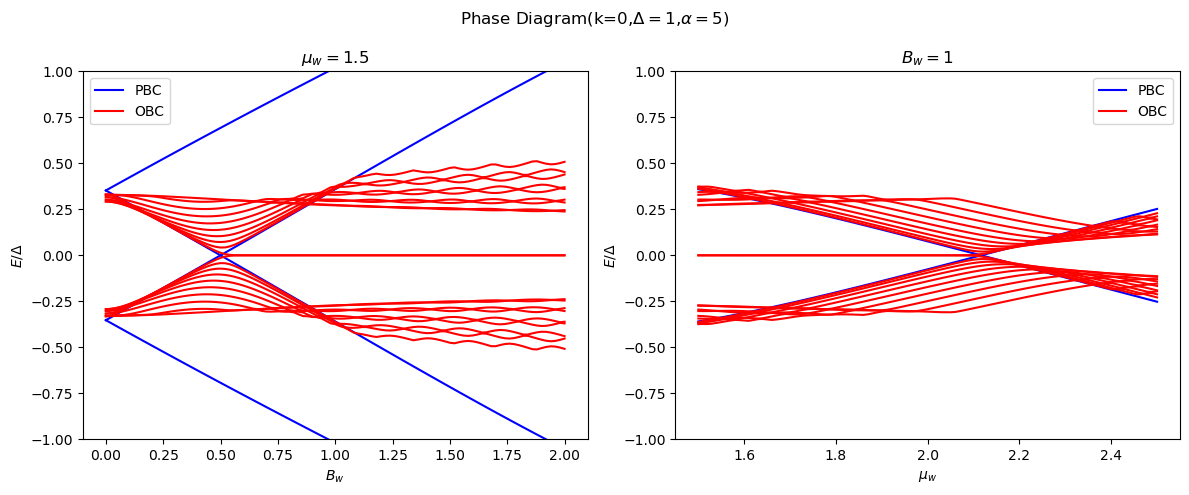

In [7]:
# %matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from full_system import *

# PBC_Params = {
#     "L": 300,
#     "alpha": 0.8,
#     "Bw": 0.2,
#     "mu_w": 0.1,
#     "tw": 12,

#     "Bs": 0,
#     "mu_s": 0,
#     "ts": 6,
#     "delta": 1,
#     "T": 0.4,
#     "BdG" : True,
#     "PBC" : True
# }

PBC_Params = {
    "L": 300,
    "alpha": 5,
    "Bw": 1,
    "mu_w": 1.5,
    "tw": 27.2,
    "Bs": 0,
    "mu_s": 3,
    "ts": 6,
    "delta": 1,
    "T": 2,
    "BdG": True,
    "PBC": True
}


OBC_Params = PBC_Params.copy()
OBC_Params["PBC"] = False

Bw_range = np.linspace(0, 2, 101)
mu_w_range = np.linspace(1.5, 2.5, 101)


def compute_spectrum(param_range, sys_params, xlabel):
    E = []

    for param in param_range:
        p = sys_params.copy()
        if xlabel == 'B':
            p['Bw'] = param
        if xlabel == '$\\mu$':
            p['mu_w'] = param
        sys = sys_bands(p).finalized()
        
        if sys_params["PBC"]:
            band_sys = kwant.physics.Bands(sys)
            E.append(band_sys(0))
        else:
            ham = sys.hamiltonian_submatrix()
            eng = eigsh(ham, k=20, sigma=1e-10, return_eigenvectors=False)
            E.append(np.sort(eng))
    return E


E_B_pbc = compute_spectrum(Bw_range, PBC_Params, xlabel='B')
E_B_obc = compute_spectrum(Bw_range, OBC_Params, xlabel='B')
E_mu_pbc = compute_spectrum(mu_w_range, PBC_Params, xlabel='$\\mu$')
E_mu_obc = compute_spectrum(mu_w_range, OBC_Params, xlabel='$\\mu$')


# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Phase Diagram(k=0,$\\Delta={PBC_Params["delta"]}$,$\\alpha={PBC_Params["alpha"]}$)')

# Energy vs Magnetic Field
axes[0].plot(Bw_range, E_B_pbc, 'b')
axes[0].plot(Bw_range, E_B_obc, 'r')
axes[0].set_xlabel('$B_w$')
axes[0].set_ylabel('$E/\\Delta$')
axes[0].set_ylim(-1, 1)
# axes[0].set_xlim(0,)
axes[0].set_title(f'$\\mu_w={PBC_Params["mu_w"]}$')

axes[0].plot(Bw_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[0].plot(Bw_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[0].legend()

# Energy vs Chemical Potential
axes[1].plot(mu_w_range, E_mu_pbc, 'b')
axes[1].plot(mu_w_range, E_mu_obc, 'r')
axes[1].set_xlabel('$\\mu_w$')
axes[1].set_ylabel('$E/\\Delta$')
axes[1].set_ylim(-1, 1)
# axes[1].set_xlim(0,)
axes[1].set_title(f'$B_w={PBC_Params["Bw"]}$')

axes[1].plot(mu_w_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[1].plot(mu_w_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[1].legend()

plt.tight_layout()
plt.show()

# B,mu phase

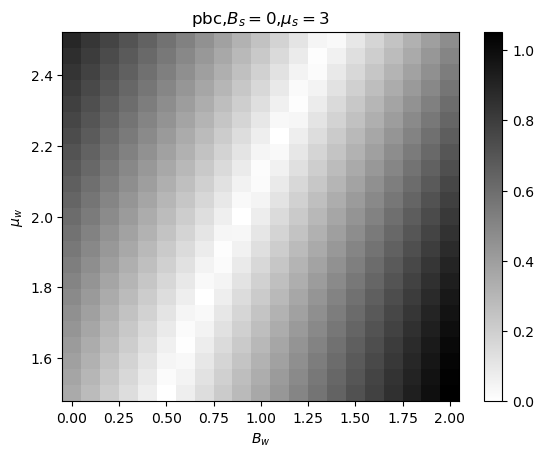

In [8]:
from full_system import *
import matplotlib.pyplot as plt

PBC_Params = {
    "L": 300,
    "alpha": 5,
    "Bw": 1,
    "mu_w": 1.5,
    "tw": 27.2,
    "Bs": 0,
    "mu_s": 3,
    "ts": 6,
    "delta": 1,
    "T": 2,
    "BdG": True,
    "PBC": True
}

def compute_phase_pbc(B_range, mu_range):
    E = np.zeros((len(B_range),len(mu_range)))
    for i,Bw in enumerate(B_range):
        for j,mu_w in enumerate(mu_range):
            PBC_Params["Bw"] = Bw
            PBC_Params["mu_w"] = mu_w
            sys = sys_bands(PBC_Params).finalized()
            band_sys = kwant.physics.Bands(sys)
            E[i,j] = np.min(np.abs(band_sys(0)))
    return E

# Compute data
B_range = np.linspace(0, 2, 21)
mu_range = np.linspace(1.5, 2.5, 23)
E_pbc = compute_phase_pbc(B_range, mu_range)


X, Y = np.meshgrid(B_range, mu_range)
plt.figure()
plt.pcolormesh(X, Y, E_pbc.T, cmap='binary', shading='auto') 
plt.title(f'pbc,$B_s=${PBC_Params["Bs"]},$\\mu_s=${PBC_Params["mu_s"]}')
plt.xlabel('$B_w$')
plt.ylabel('$\\mu_w$')
cbar = plt.colorbar()  
plt.show()